In [161]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import os
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [162]:
paths = []
labels = []
genders = []

# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename
        folder_name = os.path.basename(dirname)
        label_gender = folder_name.split('_')
        if len(label_gender) == 2:  # Ensure the folder name is in the expected format
            label, gender = label_gender
        else:
            label, gender = folder_name, 'unknown'  # Default or error handling

        labels.append(label.lower())
        genders.append(gender.lower())

# Create a DataFrame with the collected data
df = pd.DataFrame({
    'speech': paths,
    'label': labels,
    'gender': genders
})

# Display the first few rows of the DataFrame to verify
print(df.head())


                                  speech    label  gender
0  data/Neutral_Female/jt_neutral_21.wav  neutral  female
1  data/Neutral_Female/ws_neutral_25.wav  neutral  female
2  data/Neutral_Female/ws_neutral_31.wav  neutral  female
3  data/Neutral_Female/ws_neutral_19.wav  neutral  female
4   data/Neutral_Female/neutral_xn_1.wav  neutral  female


In [163]:
# merge label and gender column into a single column
df['label'] = df['label'] + '_' + df['gender']

In [164]:
print(df.head())

                                  speech           label  gender
0  data/Neutral_Female/jt_neutral_21.wav  neutral_female  female
1  data/Neutral_Female/ws_neutral_25.wav  neutral_female  female
2  data/Neutral_Female/ws_neutral_31.wav  neutral_female  female
3  data/Neutral_Female/ws_neutral_19.wav  neutral_female  female
4   data/Neutral_Female/neutral_xn_1.wav  neutral_female  female


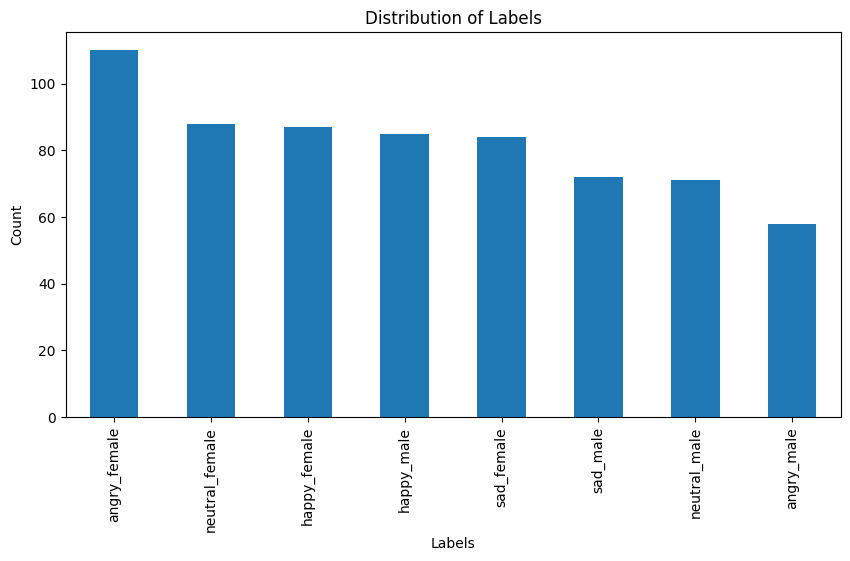

In [165]:
# plot the distribution of labels
plt.figure(figsize=(10, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [166]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

def processData(df):
    X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
    print(X_mfcc.head())
    X = [x for x in X_mfcc]
    X = np.array(X)
    X = np.expand_dims(X, -1)
    print(X.shape)

    enc = OneHotEncoder()
    y = enc.fit_transform(df[['label']])
    y = y.toarray()
    print(y.shape)
    return X, y, enc

In [167]:
X, y, enc = processData(df)

0    [-353.48593, 123.60226, -61.569126, 39.86243, ...
1    [-564.13477, 126.06131, -4.9192147, 37.11637, ...
2    [-539.20575, 138.16704, -16.331873, 54.64462, ...
3    [-492.10907, 154.77478, -30.476576, 45.752804,...
4    [-548.0422, 143.70914, -27.73417, 78.2991, -5....
Name: speech, dtype: object
(655, 40, 1)
(655, 8)


In [168]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
tf.random.set_seed(1)

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,864 (1.17 MB)

 Trainable params: 305,864 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [169]:
from sklearn.model_selection import train_test_split

# Separate the test data
x_1, x_test, y_1, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.15, shuffle=True)

# Training the Keras model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.1747 - loss: 2.0394 - val_accuracy: 0.2697 - val_loss: 1.9141
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.2793 - loss: 1.8763 - val_accuracy: 0.3483 - val_loss: 1.6681
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.3162 - loss: 1.7582 - val_accuracy: 0.3146 - val_loss: 1.5343
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.3823 - loss: 1.5915 - val_accuracy: 0.4270 - val_loss: 1.4142
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.3799 - loss: 1.5361 - val_accuracy: 0.4382 - val_loss: 1.2939
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4118 - loss: 1.4451 - val_accuracy: 0.4944 - val_loss: 1.2156
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.4638 - loss: 1.3122 - val_accuracy: 0.4719 - val_loss: 1.2556
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4298 - loss: 1.3501 - val_accuracy: 0.5506 - val_loss:

In [170]:
model.evaluate(x=x_test, y=y_test)
predictions = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8004 - loss: 0.9077
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [171]:
y_pred = enc.inverse_transform(predictions)
y_test_transform = enc.inverse_transform(y_test)

result = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
result['Predicted Labels'] = y_pred.flatten()
result['Actual Labels'] = y_test_transform.flatten()
print(len(result))

66


In [172]:
result

,Predicted Labels,Actual Labels
0,happy_male,happy_male
1,sad_female,sad_female
2,sad_male,sad_male
3,happy_female,angry_female
4,happy_female,happy_female
...,...,...
61,sad_male,happy_male
62,happy_male,happy_male
63,neutral_male,sad_male
64,sad_male,sad_male


In [173]:
# check result accuracy for gender
# extract gender from Predicted Labels and Actual Labels
result['Predict Gender'] = result['Predicted Labels'].apply(lambda x: x.split('_')[1])
result['Actual Gender'] = result['Actual Labels'].apply(lambda x: x.split('_')[1])

# check accuracy for predict gender
accuracy = (result['Predict Gender'] == result['Actual Gender']).mean()
accuracy

0.9848484848484849

In [174]:
predict_gender = result['Predict Gender'].tolist()
actual_gender = result['Actual Gender'].tolist()

# Calculate accuracy
accuracy = accuracy_score(actual_gender, predict_gender)
print(f"Accuracy of Gender Prediction: {accuracy*100:.2f}%")

Accuracy of Gender Prediction: 98.48%


In [175]:
result

,Predicted Labels,Actual Labels,Predict Gender,Actual Gender
0,happy_male,happy_male,male,male
1,sad_female,sad_female,female,female
2,sad_male,sad_male,male,male
3,happy_female,angry_female,female,female
4,happy_female,happy_female,female,female
...,...,...,...,...
61,sad_male,happy_male,male,male
62,happy_male,happy_male,male,male
63,neutral_male,sad_male,male,male
64,sad_male,sad_male,male,male


In [176]:
# count how many columns of gender are not matched
result[(result['Predict Gender'] != result['Actual Gender'])]

,Predicted Labels,Actual Labels,Predict Gender,Actual Gender
51,happy_female,happy_male,female,male


----- F1 -----
0.7405151865678181
----- AUC ROC -----
0.940978019012372
----- AUC ROC Curve -----


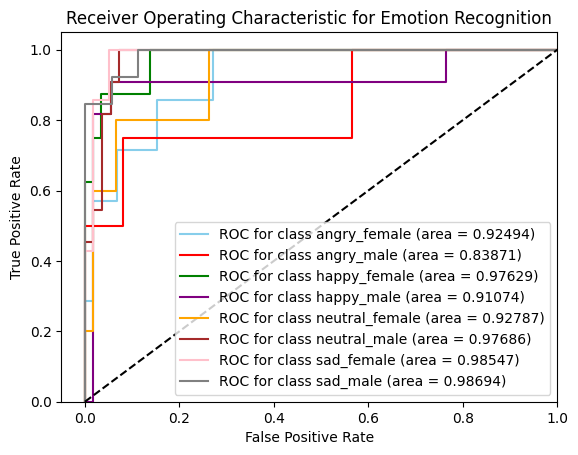

----- Confusion Matrix -----


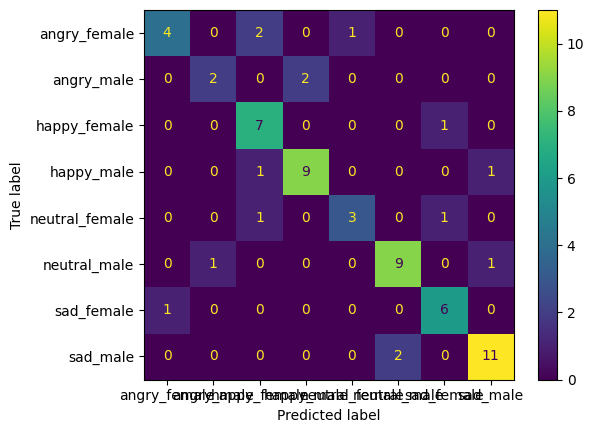

----- Classification Report -----
                precision    recall  f1-score   support

  angry_female       0.80      0.57      0.67         7
    angry_male       0.67      0.50      0.57         4
  happy_female       0.64      0.88      0.74         8
    happy_male       0.82      0.82      0.82        11
neutral_female       0.75      0.60      0.67         5
  neutral_male       0.82      0.82      0.82        11
    sad_female       0.75      0.86      0.80         7
      sad_male       0.85      0.85      0.85        13

      accuracy                           0.77        66
     macro avg       0.76      0.74      0.74        66
  weighted avg       0.78      0.77      0.77        66



In [177]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    auc,
    roc_auc_score,
    f1_score
)

print("----- F1 -----")
print(f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average="macro"))

print("----- AUC ROC -----")
print(roc_auc_score(y_test, predictions, multi_class="ovr", labels=list(enc.categories_[0])))

print("----- AUC ROC Curve -----")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['skyblue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'ROC for class {list(enc.categories_[0])[i]} (area = {roc_auc[i]:.5f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Emotion Recognition')
plt.legend(loc="lower right")
plt.show()


print("----- Confusion Matrix -----")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(enc.categories_[0]))
disp.plot()
plt.show()

print("----- Classification Report -----")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names=list(enc.categories_[0])))
